In [7]:
import cv2
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

Configurations

In [8]:
IMG_SIZE = (64, 64)  # Resize images to this size
SAMPLES_PER_PERSON = 20  # Samples per person (fast collection!)

# Class names
CLASS_NAMES = ["Male", "Female"]

print("="*60)
print("GENDER CLASSIFICATION WITH LINEAR SVM")
print("="*60)
print("\nThis model will learn to classify Male vs Female faces")
print(f"Collecting {SAMPLES_PER_PERSON} samples per person")
print("="*60)

GENDER CLASSIFICATION WITH LINEAR SVM

This model will learn to classify Male vs Female faces


MULTI-PERSON DATA COLLECTION

In [9]:
def collect_gender_data():
    """Collect training images from multiple people"""
    
    # Load face detection model
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    
    cap = cv2.VideoCapture(0)
    
    if not cap.isOpened():
        print("ERROR: Could not open webcam!")
        return None, None
    
    X_data = []
    y_data = []
    person_names = []  # Track who contributed what
    
    for class_idx, class_name in enumerate(CLASS_NAMES):
        print(f"\n{'='*60}")
        print(f"COLLECTING: {class_name.upper()} DATA")
        print(f"{'='*60}")
        print(f"\n Get multiple {class_name.lower()} friends for better results!")
        
        person_num = 1
        
        while True:
            print(f"\n--- {class_name} Person #{person_num} ---")
            person_name = input(f"Enter person's name (or 'done' to finish {class_name}s): ").strip()
            
            if person_name.lower() == 'done':
                if person_num == 1:
                    print("  You need at least 1 person! Try again.")
                    continue       
                break
            
            if not person_name:
                person_name = f"{class_name}_{person_num}"
            
            print(f"\nGet {person_name} ready in front of the camera!")
            print(f"Collecting {SAMPLES_PER_PERSON} samples")
            print("Press SPACE to start")
            print("Press 'q' to quit")
            
            collected = 0
            collecting = False
            
            while collected < SAMPLES_PER_PERSON:
                ret, frame = cap.read()
                if not ret:
                    print("Failed to grab frame")
                    break
                
                # Flip frame for mirror effect
                frame = cv2.flip(frame, 1)
                
                # Detect faces
                gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                faces = face_cascade.detectMultiScale(gray, 1.3, 5)
                
                # Draw rectangle around face
                for (x, y, w, h) in faces:
                    cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
                    cv2.putText(frame, "Face Detected", (x, y-10),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
                
                # Display info on frame
                cv2.putText(frame, f"{class_name}: {person_name}", (10, 30),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 255), 2)
                cv2.putText(frame, f"Person #{person_num}", (10, 65),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2)
                cv2.putText(frame, f"Progress: {collected}/{SAMPLES_PER_PERSON}", (10, 100),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 255), 2)
                
                if collecting:
                    cv2.putText(frame, "COLLECTING...", (10, 135),
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
                    # Show progress bar
                    progress_width = int((collected / SAMPLES_PER_PERSON) * 600)
                    cv2.rectangle(frame, (10, 150), (610, 180), (100, 100, 100), 2)
                    cv2.rectangle(frame, (10, 150), (10 + progress_width, 180), (0, 255, 0), -1)
                else:
                    cv2.putText(frame, "Press SPACE to start", (10, 135),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 0), 2)
                
                # Show face detection status
                if len(faces) > 0:
                    cv2.putText(frame, f" {len(faces)} face(s) detected", (10, 200),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
                else:
                    cv2.putText(frame, " No face detected", (10, 200),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
                
                cv2.imshow('Gender Classification - Data Collection', frame)
                
                key = cv2.waitKey(1) & 0xFF
                
                if key == ord(' '):
                    collecting = True
                    print(f"  Started collecting from {person_name}...")
                elif key == ord('q'):
                    cap.release()
                    cv2.destroyAllWindows()
                    return None, None
                
                if collecting and len(faces) > 0:
                    # Convert to grayscale and resize
                    resized = cv2.resize(gray, IMG_SIZE)
                    
                    # Flatten image to 1D array
                    flattened = resized.flatten()
                    
                    X_data.append(flattened)
                    y_data.append(class_idx)
                    person_names.append(f"{class_name}_{person_name}")
                    collected += 1
                    
                    # Small delay between captures
                    time.sleep(0.05)
            
            print(f"   Collected {collected} samples from {person_name}!")
            person_num += 1
            
            # Ask if they want to add more people
            if person_num > 1:
                more = input(f"\n  Add another {class_name.lower()} person? (y/n): ").lower()
                if more != 'y':
                    break
        
        print(f"\n✓ Finished collecting all {class_name} data!")
        print(f"  Total {class_name} samples: {sum(1 for y in y_data if y == class_idx)}")
    
    cap.release()
    cv2.destroyAllWindows()
    
    # Summary
    print(f"\n{'='*60}")
    print("DATA COLLECTION SUMMARY")
    print(f"{'='*60}")
    unique_people = set(person_names)
    print(f"Total samples: {len(X_data)}")
    print(f"Unique people: {len(unique_people)}")
    print(f"\nBreakdown by person:")
    for person in sorted(unique_people):
        count = sum(1 for p in person_names if p == person)
        print(f"  {person}: {count} samples")
    
    return np.array(X_data), np.array(y_data)


Traning the Gender Classification Model

In [10]:
def train_gender_classifier(X, y):
    """Train Linear SVM for gender classification"""
    print("\n" + "="*60)
    print("TRAINING GENDER CLASSIFIER")
    print("="*60)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"\nTraining set: {X_train.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")
    print(f"Feature dimensions: {X_train.shape[1]} (from {IMG_SIZE[0]}x{IMG_SIZE[1]} images)")
    
    # Standardize features
    print("\nStandardizing features...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train Linear SVM
    print("Training Linear SVM...")
    model = SVC(kernel='linear', C=1.0, probability=True, random_state=42)
    model.fit(X_train_scaled, y_train)
    
    # Evaluate on test set
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"\n{'='*60}")
    print("MODEL PERFORMANCE")
    print(f"{'='*60}")
    print(f"Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=CLASS_NAMES))
    
    # Cross-validation
    print("Performing 5-fold cross-validation...")
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    print(f"Cross-validation scores: {[f'{s:.3f}' for s in cv_scores]}")
    print(f"Mean CV accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    
    # Support vectors info
    print(f"\n{'='*60}")
    print("SUPPORT VECTOR ANALYSIS")
    print(f"{'='*60}")
    print(f"Total support vectors: {len(model.support_)}")
    print(f"Support vectors per class:")
    for i, class_name in enumerate(CLASS_NAMES):
        print(f"  {class_name}: {model.n_support_[i]}")
    print(f"Percentage of training data as SVs: {len(model.support_)/len(X_train)*100:.1f}%")
    
    # Interpretation
    if accuracy > 0.85:
        print("\n Excellent accuracy! Model should work well on new people!")
    elif accuracy > 0.75:
        print("\n Good accuracy! Model generalizes reasonably well.")
    elif accuracy > 0.65:
        print("\n Moderate accuracy. Consider collecting more diverse data.")
    else:
        print("\n Low accuracy. Need more people or more samples per person.")
    
    # Plot confusion matrix
    plot_confusion_matrix(y_test, y_pred)
    
    return model, scaler, accuracy


def plot_confusion_matrix(y_test, y_pred):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
                cbar_kws={'label': 'Count'}, annot_kws={'size': 16})
    plt.title('Confusion Matrix - Gender Classification', fontweight='bold', fontsize=14)
    plt.ylabel('Actual Gender', fontsize=12)
    plt.xlabel('Predicted Gender', fontsize=12)
    plt.tight_layout()
    plt.savefig('gender_confusion_matrix.png', dpi=300, bbox_inches='tight')
    print("\n✓ Confusion matrix saved as 'gender_confusion_matrix.png'")
    plt.show()

Real-Time Gender Prediction


In [11]:
def real_time_gender_prediction(model, scaler):
    """Run real-time gender classification"""
    print("\n" + "="*60)
    print("REAL-TIME GENDER CLASSIFICATION")
    print("="*60)
    print("Press 'q' to quit")
    print("Press 's' to save screenshot\n")
    
    # Load face detection
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    
    cap = cv2.VideoCapture(0)
    
    if not cap.isOpened():
        print("ERROR: Could not open webcam!")
        return
    
    screenshot_count = 0
    
    print("Webcam opened! Try it with different people to test generalization!")
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        # Flip frame for mirror effect
        frame = cv2.flip(frame, 1)
        
        # Detect faces
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)
        
        # Process each detected face
        for (x, y, w, h) in faces:
            # Extract face region
            face_gray = gray[y:y+h, x:x+w]
            
            # Preprocess
            resized = cv2.resize(face_gray, IMG_SIZE)
            flattened = resized.flatten().reshape(1, -1)
            
            # Scale and predict
            scaled = scaler.transform(flattened)
            prediction = model.predict(scaled)[0]
            probabilities = model.predict_proba(scaled)[0]
            confidence = probabilities[prediction] * 100
            decision = model.decision_function(scaled)[0]
            
            # Determine gender and color
            predicted_gender = CLASS_NAMES[prediction]
            # Blue for Male, Pink for Female
            color = (255, 0, 0) if prediction == 0 else (255, 0, 255)
            
            # Draw rectangle around face
            cv2.rectangle(frame, (x, y), (x+w, y+h), color, 3)
            
            # Display prediction above face
            label = f"{predicted_gender}: {confidence:.1f}%"
            (label_w, label_h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.8, 2)
            cv2.rectangle(frame, (x, y-label_h-10), (x+label_w, y), color, -1)
            cv2.putText(frame, label, (x, y-5),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
            
            # Display distance from hyperplane below face
            dist_label = f"Margin: {abs(decision):.2f}"
            cv2.putText(frame, dist_label, (x, y+h+25),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
        
        # Display stats on frame
        cv2.putText(frame, f"Faces detected: {len(faces)}", (10, 30),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
        cv2.putText(frame, "Press 'q' to quit | 's' to screenshot", (10, frame.shape[0]-10),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
        
        cv2.imshow('Gender Classification - Real-Time', frame)
        
        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'):
            break
        elif key == ord('s'):
            screenshot_count += 1
            filename = f'gender_prediction_{screenshot_count}.jpg'
            cv2.imwrite(filename, frame)
            print(f"✓ Screenshot saved: {filename}")
    
    cap.release()
    cv2.destroyAllWindows()

# ============================================
# MAIN EXECUTION
# ============================================
def main():
    print("\n Starting Gender Classification System")
    print("Make sure you have good lighting and faces are clearly visible!")
    print("\nStarting in 3 seconds...")
    time.sleep(3)
    
    # Step 1: Collect data
    print("\n" + "="*60)
    print("STEP 1: DATA COLLECTION")
    print("="*60)
    print("Each person takes only ~2 seconds to collect!\n")
    
    X_data, y_data = collect_gender_data()
    
    if X_data is None:
        print("Data collection cancelled.")
        return
    
    if len(X_data) < 20:
        print("\nWarning: Very few samples collected. Results may be poor.")
        cont = input("Continue anyway? (y/n): ").lower()
        if cont != 'y':
            return
    
    # Step 2: Train model
    model, scaler, accuracy = train_gender_classifier(X_data, y_data)
    
    # Step 3: Save model
    print("\n" + "="*60)
    save_model = input("\nSave model for later use? (y/n): ").lower()
    if save_model == 'y':
        with open('gender_classifier.pkl', 'wb') as f:
            pickle.dump((model, scaler, CLASS_NAMES, accuracy), f)
        print("Model saved to 'gender_classifier.pkl'")
        print("You can load this later to skip training!")
    
    # Step 4: Real-time prediction
    if accuracy > 0.6:
        start_prediction = input("\nStart real-time prediction? (y/n): ").lower()
        if start_prediction == 'y':
            real_time_gender_prediction(model, scaler)
    else:
        print("\n  Warning: Model accuracy is too low ({accuracy:.1%}).")
        print("Skipping real-time prediction. Collect more diverse data and retrain!")
    
    print("\n" + "="*60)
    print(" GENDER CLASSIFICATION COMPLETE!")
    print("="*60)

# ============================================
# LOAD SAVED MODEL (OPTIONAL)
# ============================================
def load_and_predict():
    """Load a saved model and run predictions"""
    try:
        with open('gender_classifier.pkl', 'rb') as f:
            model, scaler, class_names, accuracy = pickle.load(f)
        
        print(f" Model loaded successfully!")
        print(f"  Training accuracy: {accuracy:.4f} ({accuracy*100:.1f}%)")
        real_time_gender_prediction(model, scaler)
    except FileNotFoundError:
        print(" No saved model found ('gender_classifier.pkl').")
        print("Train a new model first by selecting option 1!")


Testing the program


GENDER CLASSIFICATION WITH LINEAR SVM

Options:
1. Train new model (collect data from multiple people)
2. Load saved model (skip training)

 Starting Gender Classification System
Make sure you have good lighting and faces are clearly visible!

Starting in 3 seconds...

STEP 1: DATA COLLECTION
Each person takes only ~2 seconds to collect!


COLLECTING: MALE DATA

 Get multiple male friends for better results!

--- Male Person #1 ---

Get joshua ready in front of the camera!
Press SPACE to start
Press 'q' to quit
  Started collecting from joshua...
   Collected 20 samples from joshua!

✓ Finished collecting all Male data!
  Total Male samples: 20

COLLECTING: FEMALE DATA

 Get multiple female friends for better results!

--- Female Person #1 ---

Get fem 1 ready in front of the camera!
Press SPACE to start
Press 'q' to quit
  Started collecting from fem 1...
   Collected 20 samples from fem 1!

✓ Finished collecting all Female data!
  Total Female samples: 20

DATA COLLECTION SUMMARY
To

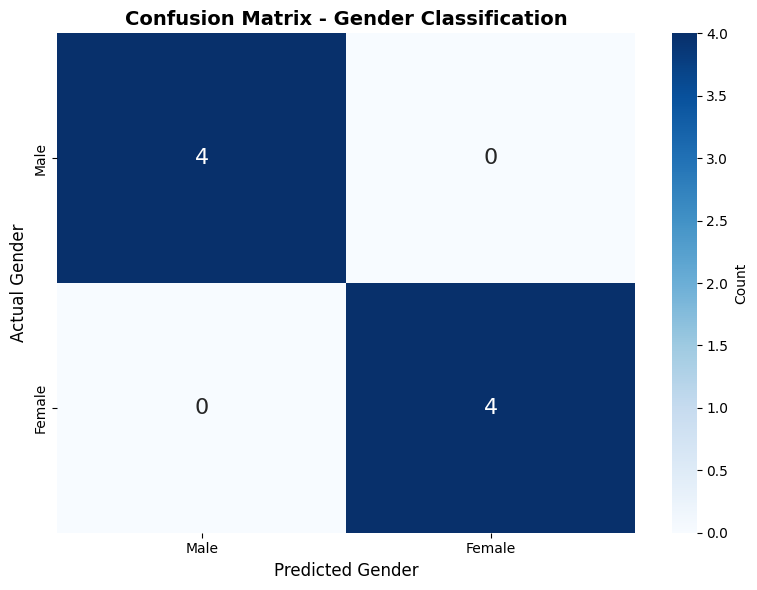


Model saved to 'gender_classifier.pkl'
You can load this later to skip training!

REAL-TIME GENDER CLASSIFICATION
Press 'q' to quit
Press 's' to save screenshot

Webcam opened! Try it with different people to test generalization!

 GENDER CLASSIFICATION COMPLETE!


In [12]:
if __name__ == "__main__":
    print("\n" + "="*60)
    print("GENDER CLASSIFICATION WITH LINEAR SVM")
    print("="*60)
    print("\nOptions:")
    print("1. Train new model (collect data from multiple people)")
    print("2. Load saved model (skip training)")
    
    choice = input("\nEnter choice (1 or 2): ").strip()
    
    if choice == '2':
        load_and_predict()
    else:
        main()